In [1]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

pd.set_option('display.max_rows', 1000)

In [2]:
!ls

Comext Open Data.ipynb
Country Distance
Instructions on how to use the bulkdownload facility.pdf
Readme.md
country_codes.csv
our_data
total_dataframe.csv


In [3]:
%%time
main_dir = 'our_data/'

path_hs = main_dir + 'transportation_hs'
all_hs = glob.glob(path_hs + "/*.dat")

list_df_hs = []

for filename in all_hs:
    df_tmp_hs = pd.read_csv(filename, index_col=None, header=0)
    list_df_hs.append(df_tmp_hs)

df_hs = pd.concat(list_df_hs, axis=0, ignore_index=True)

path_nstr = main_dir + 'transportation_nstr'
all_nstr = glob.glob(path_nstr + "/*.dat")

list_df_nstr = []

for filename in all_nstr:
    df_tmp_nstr = pd.read_csv(filename, index_col=None, header=0)
    list_df_nstr.append(df_tmp_nstr)

df_nstr = pd.concat(list_df_nstr, axis=0, ignore_index=True)

<decorator-gen-54>:2: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.


CPU times: user 45 s, sys: 8.63 s, total: 53.6 s
Wall time: 57.9 s


# DataFrames

## Description of the columns of df_hs DataFrame

* **DECLARANT and DECLARANT_ISO**: The Declarant (or reporting country) is the country compiling and sending data to Eurostat.
* **PARTNER and PARTNER_ISO**: The partner country is the last known country of destination for exports, the country of origin for imports from non-EU countries and the country of consignment for imports from Member States.
* **PRODUCT_HS**: file txt CN, SITC, CPA_2002, CPA_2008, CPA_2.1, BEC or by SECTION.
* **FLOW**: 1 import, 2 export.
* **TRANSPORT_MODE**: file txt in the main folder
* **PERIOD**: This code refers to the reference period.
* **VALUE_IN_EUROS**: euros already numpy.int64.
* **QUANTITY_IN_KG**: kg already numpy.int64.

In [4]:
# open the ransport mode txt file
transp_mode = pd.read_csv('our_data/TRANSPORT_MODE.txt', sep= '\t').rename({'0':'TRANSPORT_MODE', 'Unknown':'TYPE_TRANSP_MODE'}, axis=1)

# merge the dataframes
df_hs = df_hs.merge(transp_mode, on='TRANSPORT_MODE')

# create a dataframe for the flow
flow = pd.DataFrame({'FLOW':[1,2], 'TYPE_FLOW':['import', 'export']})

# merge the dataframes
df_hs = df_hs.merge(flow, on='FLOW')

# clear the period in two columns MONTH and YEAR
df_hs['MONTH'] = df_hs['PERIOD'].apply(lambda x: str(x)[4:])
df_hs['YEAR'] = df_hs['PERIOD'].apply(lambda x: str(x)[:4])

# drop the column PERIOD
df_hs.drop('PERIOD', axis=1, inplace=True)

In [5]:
df_hs[df_hs['PRODUCT_HS']=='TOTAL']; # can I delete this, right?

## Description of the columns of df_hs DataFrame

In [6]:
df_nstr = df_nstr.merge(transp_mode, on='TRANSPORT_MODE')

# merge the dataframes
df_nstr = df_nstr.merge(flow, on='FLOW')

# clear the period in two columns MONTH and YEAR
df_nstr['MONTH'] = df_nstr['PERIOD'].apply(lambda x: str(x)[4:])
df_nstr['YEAR'] = df_nstr['PERIOD'].apply(lambda x: str(x)[:4])

# drop the column PERIOD
df_nstr.drop('PERIOD', axis=1, inplace=True)

In [7]:
# container
cont = pd.read_csv('our_data/CONTAINER_MODE.txt', header=None, sep='\t').rename({0:'CONTAINER_MODE', 
                                                                                 1:'TYPE_CONTAINER_MODE'}, axis=1)

df_nstr = df_nstr.merge(cont, on='CONTAINER_MODE')

In [8]:
df_nstr.head()

,DECLARANT,DECLARANT_ISO,PARTNER,PARTNER_ISO,PRODUCT_NSTR,FLOW,TRANSPORT_MODE,CONTAINER_MODE,TRANSPORT_MEANS_NAT,VALUE_IN_EUROS,QUANTITY_IN_KG,TYPE_TRANSP_MODE,TYPE_FLOW,MONTH,YEAR,TYPE_CONTAINER_MODE
0,1,FR,21,XC,839,2,1,0,46,10093991,35326489,Sea,export,01,2019,Not containerised
1,1,FR,21,XC,TOT,2,1,0,46,10093991,35326489,Sea,export,01,2019,Not containerised
2,1,FR,23,XL,979,2,1,0,1,925,83,Sea,export,01,2019,Not containerised
3,1,FR,23,XL,TOT,2,1,0,1,925,83,Sea,export,01,2019,Not containerised
4,1,FR,24,IS,020,2,1,0,17,17590,23450,Sea,export,01,2019,Not containerised


# Merging of the two dataframes

In [9]:
df_hs['PRODUCT_TYPE'] = 'HS'
df_nstr['PRODUCT_TYPE'] = 'NSTR'

df_hs = df_hs.rename({'PRODUCT_HS': 'PRODUCT_CODE'}, axis=1)
df_nstr = df_nstr.rename({'PRODUCT_NSTR': 'PRODUCT_CODE'}, axis=1)

df_tot = df_hs.append(df_nstr, ignore_index=True).drop(['CONTAINER_MODE', 'TRANSPORT_MEANS_NAT', 'TYPE_CONTAINER_MODE'], axis=1)

df_tot;

In [10]:
index_del = df_tot[df_tot['PRODUCT_CODE']=='TOT'].index.union(df_tot[df_tot['PRODUCT_CODE']=='TOTAL'].index)
df_tot = df_tot.drop(index_del, axis=0).reset_index(drop=True)

In [11]:
df_tot = df_tot.sort_values(by=['YEAR', 'MONTH']).reset_index(drop=True)

In [12]:
df_tot = df_tot.dropna(how='any')

## Distance

In [13]:
distance_df = pd.read_csv('Country Distance/distance.csv').sort_values(by='InputID').reset_index(drop=True)
distance_df['InputID'] = distance_df['InputID'].apply(lambda x: x.replace(' ', ''))
distance_df['TargetID'] = distance_df['TargetID'].apply(lambda x: x.replace(' ', ''))
distance_df.head()

,InputID,TargetID,Distance
0,ABW,ZWE,1.151116e+07
1,ABW,NIC,1.633202e+06
2,ABW,NER,8.373634e+06
3,ABW,NGA,8.486833e+06
4,ABW,NIU,1.148822e+07


In [14]:
ccode_df = pd.read_csv('country_codes.csv')
ccode_df.head();

In [15]:
map_dict = pd.Series(ccode_df.iloc[:,1].values,index= ccode_df.iloc[:,2]).to_dict()

In [16]:
distance_df.replace({"InputID":map_dict,"TargetID":map_dict},inplace=True)
distance_df.head()

,InputID,TargetID,Distance
0,AW,ZW,1.151116e+07
1,AW,NI,1.633202e+06
2,AW,NE,8.373634e+06
3,AW,NG,8.486833e+06
4,AW,NU,1.148822e+07


In [17]:
distance_df = distance_df.rename({'InputID':'DECLARANT_ISO', 'TargetID':'PARTNER_ISO'}, axis=1)
df_tot = df_tot.merge(distance_df, on=['DECLARANT_ISO', 'PARTNER_ISO'])

In [19]:
df_tot.to_csv('total_dataframe.csv')

# Start from Here!!! (if you have the file)

In [20]:
# read total dataframe

df_tot = pd.read_csv('total_dataframe.csv')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [21]:
# take the mean to the value of fuel
# scarse res.
# transoform the fuel in pollution
# Mi = Vmix *Qi*kH *Ci *10-6 /Ds
# type of fuel (sea, road, ...) some data 

In [22]:
# one layout for the graph
# spring layout
# export quantity and cut-off (treshold)
# local and global measure for greenness

- first step greenness and visualize and study of artcile about scc
- implementing a meaning for scc about world trande

# Graph

In [23]:
df_tot

,Unnamed: 0,DECLARANT,DECLARANT_ISO,PARTNER,PARTNER_ISO,PRODUCT_CODE,FLOW,TRANSPORT_MODE,VALUE_IN_EUROS,QUANTITY_IN_KG,TYPE_TRANSP_MODE,TYPE_FLOW,MONTH,YEAR,PRODUCT_TYPE,Distance
0,0,1,FR,24,IS,210690,1,3,203,0,Road,import,1,2019,HS,2.439785e+06
1,1,1,FR,24,IS,220110,1,3,6826,19200,Road,import,1,2019,HS,2.439785e+06
2,2,1,FR,24,IS,392690,1,3,140,0,Road,import,1,2019,HS,2.439785e+06
3,3,1,FR,24,IS,420299,1,3,129,0,Road,import,1,2019,HS,2.439785e+06
4,4,1,FR,24,IS,610331,1,3,174,0,Road,import,1,2019,HS,2.439785e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81093271,81093271,55,LT,832,UM,939,1,1,228,47,Sea,import,6,2021,NSTR,1.095534e+07
81093272,81093272,600,CY,454,TC,150910,1,1,96,11,Sea,import,6,2021,HS,9.597193e+06
81093273,81093273,600,CY,454,TC,182,1,1,96,11,Sea,import,6,2021,NSTR,9.597193e+06
81093274,81093274,53,EE,894,TF,440711,2,1,26459,25000,Sea,export,6,2021,HS,1.191827e+07


In [24]:
# df_group = df_tot[['DECLARANT_ISO','PARTNER_ISO', 'VALUE_IN_EUROS', 'QUANTITY_IN_KG', 'Distance']].groupby(['DECLARANT_ISO', 'PARTNER_ISO']).sum().reset_index()
# df_group = df_group.merge(distance_df, on=['DECLARANT_ISO', 'PARTNER_ISO'])

In [25]:
# graph construction
ser_nodes = df_tot['DECLARANT_ISO'].append(df_tot['PARTNER_ISO'])
nodes = ser_nodes.unique()

In [26]:
df_edges = df_tot[['DECLARANT_ISO', 'PARTNER_ISO', 'Distance']]
tuple_edges = [tuple(r) for r in df_edges.to_numpy()]

In [27]:
# init graph
G = nx.DiGraph()

In [28]:
G.add_nodes_from(nodes)
G.add_weighted_edges_from(tuple_edges)

In [29]:
# by time

def timeTresh_graph(df, month, year, t=1, q=None):
    '''
    The treshold (t) is between 0 and 1
    q is the quantity to apply tresh:
        'euro' for euro
        'kg' for quantity in kg
    '''
    
    G = nx.DiGraph()
    
    # nodes by time
    # df_tot_time = df[(df['YEAR'] == year) & (df['MONTH'] == month)]
    df_tot_time = df
    
    # perc
    df_tot_time['VALUE_IN_EUROS'] = df_tot_time['VALUE_IN_EUROS'].apply(lambda x: x/sum(df_tot_time['VALUE_IN_EUROS']))
    df_tot_time['QUANTITY_IN_KG'] = df_tot_time['QUANTITY_IN_KG'].apply(lambda x: x/sum(df_tot_time['QUANTITY_IN_KG']))

    if q == 'euro':
        df_tot_time = df_tot_time[['DECLARANT_ISO', 'PARTNER_ISO', 'VALUE_IN_EUROS']]
        df_tot_time = df_tot_time[df_tot_time['VALUE_IN_EUROS']>=t]
    else:
        df_tot_time = df_tot_time[['DECLARANT_ISO', 'PARTNER_ISO', 'QUANTITY_IN_KG']]
        df_tot_time = df_tot_time[df_tot_time['QUANTITY_IN_KG']<=t]
    
    ser_nodes = df_tot_time['DECLARANT_ISO'].append(df_tot_time['PARTNER_ISO'])
    nodes = ser_nodes.unique()
    
    # edges by time
    df_edges = df_tot_time[['DECLARANT_ISO', 'PARTNER_ISO']]
    tuple_edges = [tuple(r) for r in df_edges.to_numpy()]
    
    G.add_nodes_from(nodes)
    G.add_edges_from(tuple_edges) # add weight 

    return G

In [30]:
# plt.figure(figsize=(70,40))
# nx.draw(G);

In [31]:
# plt.figure(figsize=(70,40))
# nx.draw(timeTresh_graph(df_group, '02', '2020', t = 0.6, q = 'euro'));

minimum_e = df_tot['VALUE_IN_EUROS'].min()
maximum_e = df_tot['VALUE_IN_EUROS'].max()
minimum_k = df_tot['QUANTITY_IN_KG'].min()
maximum_k = df_tot['QUANTITY_IN_KG'].max()

In [32]:
# perc
# df_tot['VALUE_IN_EUROS'] = df_tot['VALUE_IN_EUROS'].apply(lambda x: (x-minimum_e)/(maximum_e-minimum_e))
# df_tot['QUANTITY_IN_KG'] = df_tot['QUANTITY_IN_KG'].apply(lambda x: (x-minimum_k)/(maximum_k-minimum_k))
df_tot_filter = df_tot[['DECLARANT_ISO', 'PARTNER_ISO', 'Distance', 'VALUE_IN_EUROS']]

In [33]:
df_tot_filter = df_tot_filter[df_tot_filter['VALUE_IN_EUROS'] >= 1700000000]
df_tot_filter;

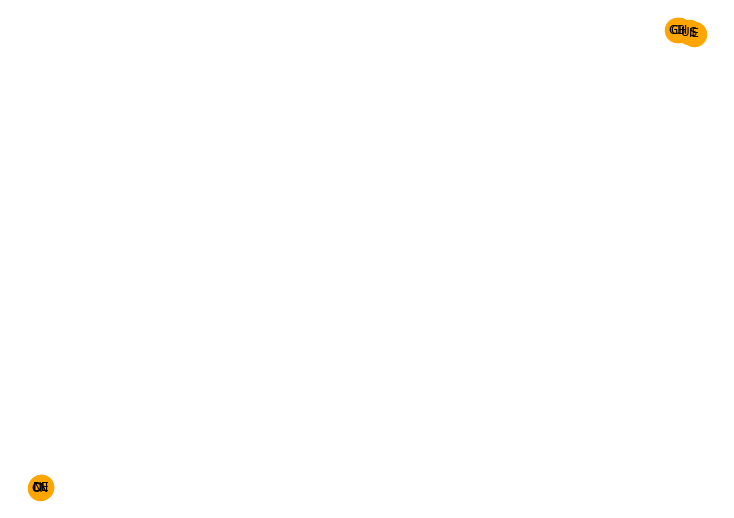

In [34]:
plt.figure(figsize=(10,7))
Gt = nx.Graph()
ser_nodes = df_tot_filter['DECLARANT_ISO'].append(df_tot_filter['PARTNER_ISO'])
nodes = ser_nodes.unique()

# edges by time
df_edges = df_tot_filter[['DECLARANT_ISO', 'PARTNER_ISO', 'Distance']]
tuple_edges = [tuple(r) for r in df_edges.to_numpy()]

Gt.add_nodes_from(nodes)
Gt.add_weighted_edges_from(tuple_edges)  
nx.draw(Gt, with_labels=True, node_size=600, node_color='orange')

# edges difference between import and export

In [35]:
# how to choice treshold for the values? 
# percentage or absolute value?
# 35L for 100 km

In [36]:
df_tot['TYPE_TRANSP_MODE'].unique()

# Road, Air, Sea, Rail are the most important (for us)

array(['Road', 'Air', 'Post', 'Sea', 'Rail', 'Self Propulsion',
       'Inland Waterway', 'Fixed Mechanism'], dtype=object)

# Continue Algorithm

In [37]:
# import export
# mesi/anno
# cosa? ma questo lo vediamo più tardi
# il tipo di trasporto?
# trashold euro/kg

In [38]:
# start with teh import/export
# import
df_import = df_tot[df_tot['TYPE_FLOW']=='import'].reset_index(drop=True)
# export
df_export = df_tot[df_tot['TYPE_FLOW']=='export'].reset_index(drop=True)

In [39]:
# work with the import
df_import.head()

,Unnamed: 0,DECLARANT,DECLARANT_ISO,PARTNER,PARTNER_ISO,PRODUCT_CODE,FLOW,TRANSPORT_MODE,VALUE_IN_EUROS,QUANTITY_IN_KG,TYPE_TRANSP_MODE,TYPE_FLOW,MONTH,YEAR,PRODUCT_TYPE,Distance
0,0,1,FR,24,IS,210690,1,3,203,0,Road,import,1,2019,HS,2.439785e+06
1,1,1,FR,24,IS,220110,1,3,6826,19200,Road,import,1,2019,HS,2.439785e+06
2,2,1,FR,24,IS,392690,1,3,140,0,Road,import,1,2019,HS,2.439785e+06
3,3,1,FR,24,IS,420299,1,3,129,0,Road,import,1,2019,HS,2.439785e+06
4,4,1,FR,24,IS,610331,1,3,174,0,Road,import,1,2019,HS,2.439785e+06


In [40]:
len(df_import)

31251106

In [41]:
# month/year
df_import_my = df_import[(df_import['MONTH']==1) & (df_import['YEAR']==2019)].reset_index(drop=True)

In [42]:
df_import_my.head()

,Unnamed: 0,DECLARANT,DECLARANT_ISO,PARTNER,PARTNER_ISO,PRODUCT_CODE,FLOW,TRANSPORT_MODE,VALUE_IN_EUROS,QUANTITY_IN_KG,TYPE_TRANSP_MODE,TYPE_FLOW,MONTH,YEAR,PRODUCT_TYPE,Distance
0,0,1,FR,24,IS,210690,1,3,203,0,Road,import,1,2019,HS,2.439785e+06
1,1,1,FR,24,IS,220110,1,3,6826,19200,Road,import,1,2019,HS,2.439785e+06
2,2,1,FR,24,IS,392690,1,3,140,0,Road,import,1,2019,HS,2.439785e+06
3,3,1,FR,24,IS,420299,1,3,129,0,Road,import,1,2019,HS,2.439785e+06
4,4,1,FR,24,IS,610331,1,3,174,0,Road,import,1,2019,HS,2.439785e+06


In [43]:
len(df_import_my)

995739

In [44]:
# type of transport (for example Road)
df_import_my_tt = df_import_my[df_import_my['TYPE_TRANSP_MODE']=='Road'].reset_index(drop=True)

In [45]:
df_import_my_tt.head()

,Unnamed: 0,DECLARANT,DECLARANT_ISO,PARTNER,PARTNER_ISO,PRODUCT_CODE,FLOW,TRANSPORT_MODE,VALUE_IN_EUROS,QUANTITY_IN_KG,TYPE_TRANSP_MODE,TYPE_FLOW,MONTH,YEAR,PRODUCT_TYPE,Distance
0,0,1,FR,24,IS,210690,1,3,203,0,Road,import,1,2019,HS,2.439785e+06
1,1,1,FR,24,IS,220110,1,3,6826,19200,Road,import,1,2019,HS,2.439785e+06
2,2,1,FR,24,IS,392690,1,3,140,0,Road,import,1,2019,HS,2.439785e+06
3,3,1,FR,24,IS,420299,1,3,129,0,Road,import,1,2019,HS,2.439785e+06
4,4,1,FR,24,IS,610331,1,3,174,0,Road,import,1,2019,HS,2.439785e+06


In [46]:
# trashold euros
df_import_my_tt_te = df_import_my_tt[df_import_my_tt['VALUE_IN_EUROS'] >= 20000000].reset_index(drop=True)

In [47]:
len(df_import_my_tt_te)

270

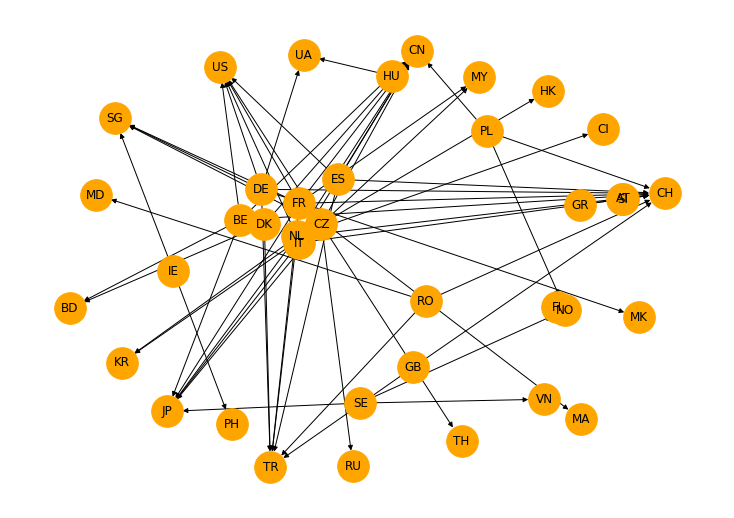

In [48]:
plt.figure(figsize=(10,7))
Gt = nx.DiGraph()
ser_nodes = df_import_my_tt_te['DECLARANT_ISO'].append(df_import_my_tt_te['PARTNER_ISO'])
nodes = ser_nodes.unique()

# edges by time
df_edges = df_import_my_tt_te[['DECLARANT_ISO', 'PARTNER_ISO', 'Distance']]
tuple_edges = [tuple(r) for r in df_edges.to_numpy()]

Gt.add_nodes_from(nodes)
Gt.add_weighted_edges_from(tuple_edges)  
nx.draw(Gt, with_labels=True, node_size=1000, node_color='orange') 

In [49]:
# main algorithm


def mainGraph(df, month = 1, year = 2019, type_flow = None, type_transport = None, type_t = None, t = 0.1):
    
    # type flow
    if type_flow == 'import':
        df = df[df['TYPE_FLOW']=='import'].reset_index(drop=True)
    elif type_flow == 'export':
        df = df[df['TYPE_FLOW']=='export'].reset_index(drop=True)
    else:
        return 'Select the type of flow!'
    
    # month and year
    if month == None or year == None or month > 12 or year > 2021 or year < 2019:
        return 'Insert correctly the month and year!'
    
    if month != None and year != None:
        df = df[(df['MONTH']==month) & (df['YEAR']==year)].reset_index(drop=True)
        
    if type_transport == None:
        return 'Select the type of transport!'
    else:
        df = df[df['TYPE_TRANSP_MODE']==type_transport].reset_index(drop=True)
    
    minimum_e = df['VALUE_IN_EUROS'].min()
    maximum_e = df['VALUE_IN_EUROS'].max()
    minimum_k = df['QUANTITY_IN_KG'].min()
    maximum_k = df['QUANTITY_IN_KG'].max()
    
    df['VALUE_IN_EUROS'] = df['VALUE_IN_EUROS'].apply(lambda x: (x-minimum_e)/(maximum_e-minimum_e))
    df['QUANTITY_IN_KG'] = df['QUANTITY_IN_KG'].apply(lambda x: (x-minimum_k)/(maximum_k-minimum_k))
    # treshold
    if type_t == 'e':
        df = df[df['VALUE_IN_EUROS'] >= t].reset_index(drop=True)
    elif type_t == 'kg':
        df = df[df['VALUE_IN_EUROS'] >= t].reset_index(drop=True)
    else:
        return 'Tell me where to apply the threshold euro or kg!'
    
    df['Distance'] = round(df['Distance'], 3)
    
    G = nx.DiGraph()
    # nodes
    nodes = df['DECLARANT_ISO'].append(df['PARTNER_ISO']).unique()
    # edges
    df_edges = df[['DECLARANT_ISO', 'PARTNER_ISO', 'Distance']]
    tuple_edges = [tuple(r) for r in df_edges.to_numpy()]
    
    # graph
    G.add_nodes_from(nodes)
    G.add_weighted_edges_from(tuple_edges)
    labels = {e: str(e) for e in G.edges}
    pos = nx.spring_layout(G, k=10000/np.sqrt(G.order()), iterations=20, scale=10)
    plt.figure(3, figsize=(20, 14))
    
    nx.draw(G, pos=pos, with_labels=True, node_size=2000, node_color='orange')

    # Create edge labels
    labels = {e: G.edges[e]['weight'] for e in G.edges}

    # Draw edge labels according to node positions
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    return G
    # return nx.draw(G, pos=pos, with_labels=True, node_size=2000, node_color='orange') 

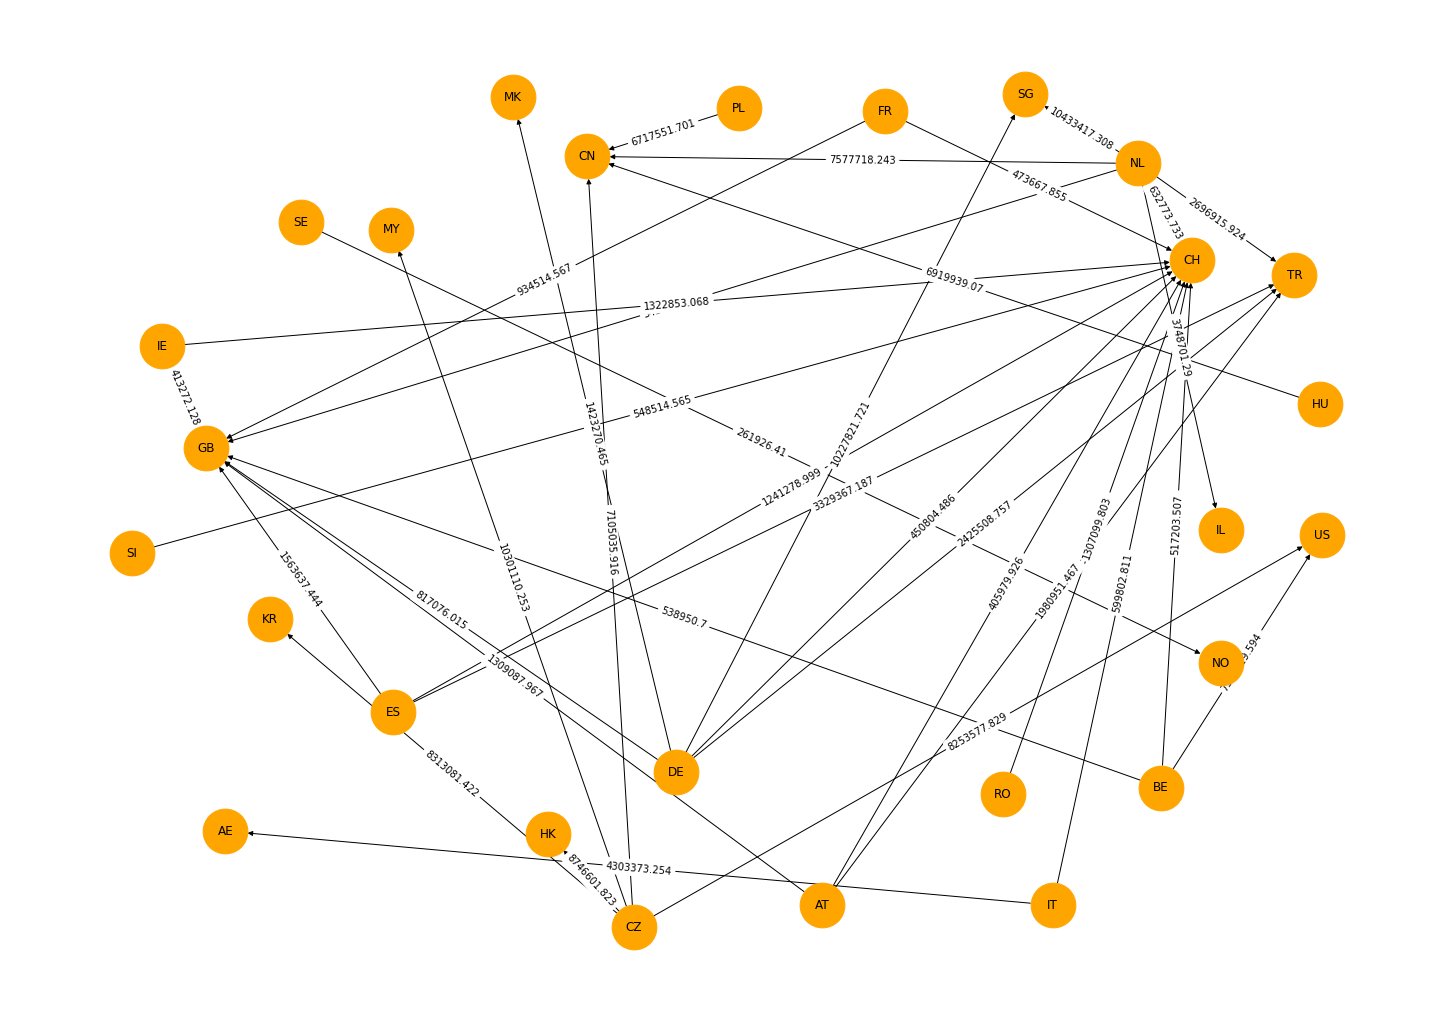

In [50]:
TradeGraph = mainGraph(df_tot, 6, 2020, 'import', 'Road', 'e', t = 0.1)

In [51]:
dic_centrality = nx.degree_centrality(TradeGraph)

In [52]:
dic_centrality = nx.degree_centrality(TradeGraph)
df_cent = pd.DataFrame(list(dic_centrality.items()),columns = ['country','centrality']).sort_values(by='centrality', ascending=False).reset_index(drop=True)
plt.figure(figsize=(20,8))
plt.bar(df_cent['country'], height=df_cent['centrality'], color='orange')
plt.xticks(fontsize=20, rotation=90)
plt.yticks(fontsize=20)
plt.show()
